<a href="https://colab.research.google.com/github/santhosh715123/Image-Inpainting-using-PConvUnet/blob/main/IMAGE_INPAINTING_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.8
!pip install keras==2.2.0

     |████████████████████████████████| 49.1MB 82kB/s 
     |████████████████████████████████| 3.1MB 38.5MB/s 
     |████████████████████████████████| 890kB 45.1MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=6ce8857161ffe5d4ba05a6be6160cbfae3bfde0fdff1737a24ab8e28ea8c5fe7
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.2.1
    Uninstalling bleach-3.2.1:
      Successfully uninstalled bleach-3.2.1
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |███████████████████████

In [ ]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 1.8.0
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: termcolor, grpcio, tensorboard, absl-py, numpy, astor, protobuf, wheel, six, gast
Required-by: fancyimpute
Name: Keras
Version: 2.2.0
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, six, h5py, keras-applications, scipy, keras-preprocessing, pyyaml
Required-by: textgenrnn, keras-vis, Keras-Preprocessing, Keras-Applications, kapre, fancyimpute


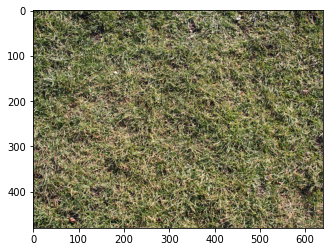

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/sample_data/1.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [ ]:
#load MASK
from random import randint
import itertools
import numpy as np
import cv2


def random_mask(height, width, channels=3):
    """Generates a random irregular mask with lines, circles and elipses"""    
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width + height) * 0.03)
    if width < 64 or height < 64:
        raise Exception("Width and Height of mask must be at least 64!")
    
    # Draw random lines
    for _ in range(randint(1, 20)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(3, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)
        
    # Draw random circles
    for _ in range(randint(1, 20)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(3, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)
        
    # Draw random ellipses
    for _ in range(randint(1, 20)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(1, width), randint(1, height)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(3, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)
    
    return 1-img

def green_mask(img_og,height, width, channels=3):
    img_mask = np.zeros((height, width, channels), np.uint8)
    img_mask2 = cv2.inRange(img_og, (0,254,0), (0,255,0))
    img_mask[:,:,0] = img_mask2
    img_mask[:,:,1] = img_mask2
    img_mask[:,:,2] = img_mask2
    return 255 - img_mask

In [ ]:
import itertools
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline

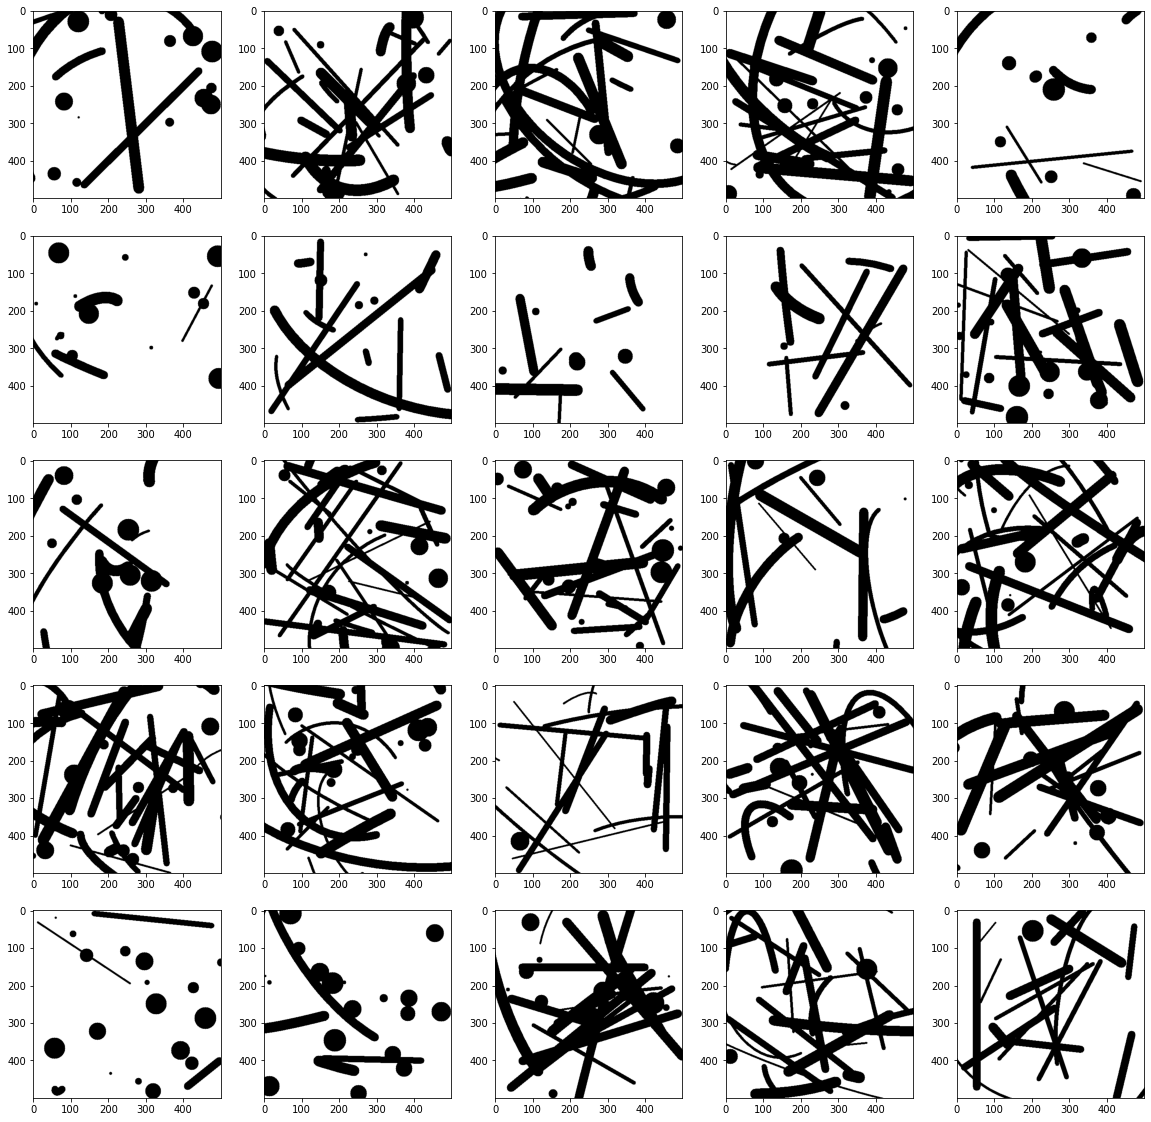

In [ ]:
# Plot the results
_, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = list(itertools.chain.from_iterable(axes))

for i in range(len(axes)):
    
    # Generate image
    img = random_mask(500, 500)
    
    # Plot image on axis
    axes[i].imshow(img*255)

In [ ]:
from tensorflow import keras as keras
import tensorflow as tf

from keras.utils import conv_utils
from keras import backend as K
from keras.engine import InputSpec
from tensorflow.python.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we set all mask values >0 to 1, and otherwise 0
        ''' 
        
        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))
            
        # Create normalization. Slight change here compared to paper, using mean mask value instead of sum
        normalization = K.mean(inputs[1], axis=[1,2], keepdims=True)
        normalization = K.repeat_elements(normalization, inputs[1].shape[1], axis=1)
        normalization = K.repeat_elements(normalization, inputs[1].shape[2], axis=2)

        # Apply convolutions to image
        img_output = K.conv2d(
            (inputs[0]*inputs[1]) / normalization, self.kernel, 
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )
        
        # Apply convolutions to mask
        mask_output = K.conv2d(
            inputs[1], self.kernel_mask, 
            strides=self.strides,
            padding=self.padding,            
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )
        
        # Where something happened, set 1, otherwise 0        
        mask_output = K.cast(K.greater(mask_output, 0), 'float32')
        
        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
                
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

In [ ]:
  
from tensorflow import keras as keras
import tensorflow as tf

import os
import numpy as np
from datetime import datetime

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras import backend as K



class PConvUnet(object):

    def __init__(self, img_rows=512, img_cols=512, weight_filepath=None, vgg_weights="imagenet", inference_only=False):
        """Create the PConvUnet. If variable image size, set img_rows and img_cols to None"""
        
        # Settings
        self.weight_filepath = weight_filepath
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.img_overlap = 30
        self.inference_only = inference_only
        
        # Assertions
        assert self.img_rows >= 256, 'Height must be >256 pixels'
        assert self.img_cols >= 256, 'Width must be >256 pixels'

        # Set current epoch
        self.current_epoch = 0
        
        # VGG layers to extract features from (first maxpooling layers, see pp. 7 of paper)
        self.vgg_layers = [3, 6, 10]
        
        # Get the vgg16 model for perceptual loss
        self.vgg = self.build_vgg(vgg_weights)
        
        # Create UNet-like model
        self.model = self.build_pconv_unet()
        
    def build_vgg(self, weights="imagenet"):
        """
        Load pre-trained VGG16 from keras applications
        Extract features to be used in loss function from last conv layer, see architecture at:
        https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py
        """        
            
        # Input image to extract features from
        img = Input(shape=(self.img_rows, self.img_cols, 3))
        
        # If inference only, just return empty model        
        if self.inference_only:
            model = Model(inputs=img, outputs=[img for _ in range(len(self.vgg_layers))])
            model.trainable = False
            model.compile(loss='mse', optimizer='adam')
            return model
                
        # Get the vgg network from Keras applications
        if weights in ['imagenet', None]:
            vgg = VGG16(weights=weights, include_top=False)
        else:
            vgg = VGG16(weights=None, include_top=False)
            vgg.load_weights(weights)

        # Output the first three pooling layers
        vgg.outputs = [vgg.layers[i].output for i in self.vgg_layers]

        # Create model and compile
        model = Model(inputs=img, outputs=vgg(img))
        model.trainable = False
        model.compile(loss='mse', optimizer='adam')
        
        return model
        
    def build_pconv_unet(self, train_bn=True, lr=0.0002):      

        # INPUTS
        inputs_img = Input((self.img_rows, self.img_cols, 3), name='inputs_img')
        inputs_mask = Input((self.img_rows, self.img_cols, 3), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(d_conv16)        
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        # Compile the model
        model.compile(
            optimizer = Adam(lr=lr),
            loss=self.loss_total(inputs_mask)
        )

        return model
    
    def loss_total(self, mask):
        """
        Creates a loss function which sums all the loss components 
        and multiplies by their weights. See paper eq. 7.
        """
        def loss(y_true, y_pred):
            
            # Compute predicted image with non-hole pixels set to ground truth
            y_comp = mask * y_true + (1-mask) * y_pred
            
            # Compute the vgg features
            vgg_out = self.vgg(y_pred)            
            vgg_gt = self.vgg(y_true)
            vgg_comp = self.vgg(y_comp)
            
            # Compute loss components
            l1 = self.loss_valid(mask, y_true, y_pred)
            l2 = self.loss_hole(mask, y_true, y_pred)
            l3 = self.loss_perceptual(vgg_out, vgg_gt, vgg_comp)
            l4 = self.loss_style(vgg_out, vgg_gt)
            l5 = self.loss_style(vgg_comp, vgg_gt)
            l6 = self.loss_tv(mask, y_comp)
            
            # Return loss function
            return l1 + 6*l2 + 0.05*l3 + 120*(l4+l5) + 0.1*l6

        return loss
    
    def loss_hole(self, mask, y_true, y_pred):
        """Pixel L1 loss within the hole / mask"""
        return self.l1((1-mask) * y_true, (1-mask) * y_pred)
    
    def loss_valid(self, mask, y_true, y_pred):
        """Pixel L1 loss outside the hole / mask"""
        return self.l1(mask * y_true, mask * y_pred)
    
    def loss_perceptual(self, vgg_out, vgg_gt, vgg_comp): 
        """Perceptual loss based on VGG16, see. eq. 3 in paper"""       
        loss = 0
        for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
            loss += self.l1(o, g) + self.l1(c, g)
        return loss
        
    def loss_style(self, output, vgg_gt):
        """Style loss based on output/computation, used for both eq. 4 & 5 in paper"""
        loss = 0
        for o, g in zip(output, vgg_gt):
            loss += self.l1(self.gram_matrix(o), self.gram_matrix(g))
        return loss
    
    def loss_tv(self, mask, y_comp):
        """Total variation loss, used for smoothing the hole region, see. eq. 6"""

        # Create dilated hole region using a 3x3 kernel of all 1s.
        kernel = K.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

        # Cast values to be [0., 1.], and compute dilated hole region of y_comp
        dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
        P = dilated_mask * y_comp

        # Calculate total variation loss
        a = self.l1(P[:,1:,:,:], P[:,:-1,:,:])
        b = self.l1(P[:,:,1:,:], P[:,:,:-1,:])        
        return a+b

    def fit(self, generator, epochs=10, plot_callback=None, *args, **kwargs):
        """Fit the U-Net to a (images, targets) generator
        
        param generator: training generator yielding (maskes_image, original_image) tuples
        param epochs: number of epochs to train for
        param plot_callback: callback function taking Unet model as parameter
        """
        
        # Loop over epochs
        for _ in range(epochs):            
            
            # Fit the model
            self.model.fit_generator(
                generator,
                epochs=self.current_epoch+1,
                initial_epoch=self.current_epoch,
                *args, **kwargs
            )

            # Update epoch 
            self.current_epoch += 1
            
            # After each epoch predict on test images & show them
            if plot_callback:
                plot_callback(self.model)

            # Save logfile
            if self.weight_filepath:
                self.save()    

    def summary(self):
        """Get summary of the UNet model"""
        print(self.model.summary())

    def save(self):        
        self.model.save_weights(self.current_weightfile())

    def load(self, filepath, train_bn=True, lr=0.0002):

        # Create UNet-like model
        self.model = self.build_pconv_unet(train_bn, lr)

        # Load weights into model
        epoch = int(os.path.basename(filepath).split("_")[0])
        assert epoch > 0, "Could not parse weight file. Should start with 'X_', with X being the epoch"
        self.current_epoch = epoch
        self.model.load_weights(filepath)        

    def current_weightfile(self):
        assert self.weight_filepath != None, 'Must specify location of logs'
        return self.weight_filepath + "{}_weights_{}.h5".format(self.current_epoch, self.current_timestamp())

    @staticmethod
    def current_timestamp():
        return datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    @staticmethod
    def l1(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.sum(K.abs(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.sum(K.abs(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")
    
    @staticmethod
    def gram_matrix(x, norm_by_channels=False):
        """Calculate gram matrix used in style loss"""
        
        # Assertions on input
        assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
        assert K.image_data_format() == 'channels_last', "Please use channels-last format"        
        
        # Permute channels and get resulting shape
        x = K.permute_dimensions(x, (0, 3, 1, 2))
        shape = K.shape(x)
        B, C, H, W = shape[0], shape[1], shape[2], shape[3]
        
        # Reshape x and do batch dot product
        features = K.reshape(x, K.stack([B, C, H*W]))
        gram = K.batch_dot(features, features, axes=2)
        
        # Normalize with channels, height and width
        gram = gram /  K.cast(C * H * W, x.dtype)
        
        return gram
    
    # Prediction functions
    ######################
    def predict(self, sample, **kwargs):
        """Run prediction using this model"""
        return self.model.predict(sample, **kwargs)
    
    def scan_predict(self, sample, **kwargs):
        """Run prediction on arbitrary image sizes"""
        
        # Only run on a single image at a time
        img = sample[0]
        mask = sample[1]
        assert len(img.shape) == 3, "Image dimension expected to be (H, W, C)"
        assert len(mask.shape) == 3, "Image dimension expected to be (H, W, C)"
        
        # Chunk up, run prediction, and reconstruct
        chunked_images = self.dimension_preprocess(img)
        chunked_masks = self.dimension_preprocess(mask)
        pred_imgs = self.predict([chunked_images, chunked_masks], **kwargs)
        reconstructed_image = self.dimension_postprocess(pred_imgs, img)
        
        # Return single reconstructed image
        return reconstructed_image    
    
    def perform_chunking(self, img_size, chunk_size):
        """
        Given an image dimension img_size, return list of (start, stop) 
        tuples to perform chunking of chunk_size
        """
        chunks, i = [], 0
        while True:
            chunks.append((i*(chunk_size - self.img_overlap/2), i*(chunk_size - self.img_overlap/2)+chunk_size))
            i+=1
            if chunks[-1][1] > img_size:
                break
        n_count = len(chunks)        
        chunks[-1] = tuple(x - (n_count*chunk_size - img_size - (n_count-1)*self.img_overlap/2) for x in chunks[-1])
        chunks = [(int(x), int(y)) for x, y in chunks]
        return chunks
    
    def get_chunks(self, img):
        """Get width and height lists of (start, stop) tuples for chunking of img"""
        x_chunks, y_chunks = [(0, 512)], [(0, 512)]        
        if img.shape[0] > self.img_rows:
            x_chunks = self.perform_chunking(img.shape[0], self.img_rows)
        if img.shape[1] > self.img_cols:
            y_chunks = self.perform_chunking(img.shape[1], self.img_cols)
        return x_chunks, y_chunks    
    
    def dimension_preprocess(self, img):
        """
        In case of prediction on image of different size than 512x512,
        this function is used to add padding and chunk up the image into pieces
        of 512x512, which can then later be reconstructed into the original image
        using the dimension_postprocess() function.
        """

        # Assert single image input
        assert len(img.shape) == 3, "Image dimension expected to be (H, W, C)"

        # Check if height is too small
        if img.shape[0] < self.img_rows:
            padding = np.ones((self.img_rows - img.shape[0], img.shape[1], img.shape[2]))
            img = np.concatenate((img, padding), axis=0)

        # Check if width is too small
        if img.shape[1] < self.img_cols:
            padding = np.ones((img.shape[0], self.img_cols - img.shape[1], img.shape[2]))
            img = np.concatenate((img, padding), axis=1)

        # Get chunking of the image
        x_chunks, y_chunks = self.get_chunks(img)

        # Chunk up the image
        images = []
        for x in x_chunks:
            for y in y_chunks:
                images.append(
                    img[x[0]:x[1], y[0]:y[1], :]
                )
        images = np.array(images)        
        return images

    def dimension_postprocess(self, chunked_images, original_image):
        """
        In case of prediction on image of different size than 512x512,
        the dimension_preprocess  function is used to add padding and chunk 
        up the image into pieces of 512x512, and this function is used to 
        reconstruct these pieces into the original image.
        """

        # Assert input dimensions
        assert len(original_image.shape) == 3, "Image dimension expected to be (H, W, C)"
        assert len(chunked_images.shape) == 4, "Chunked images dimension expected to be (B, H, W, C)"

        # Check if height is too small
        if original_image.shape[0] < self.img_rows:
            new_images = []
            for img in chunked_images:
                new_images.append(img[0:original_image.shape[0], :, :])
            chunked_images = np.array(new_images)
            
        # Check if width is too small
        if original_image.shape[1] < self.img_cols:
            new_images = []
            for img in chunked_images:
                new_images.append(img[:, 0:original_image.shape[1], :])
            chunked_images = np.array(new_images)
            
        # Put reconstruction into this array
        reconstruction = np.zeros(original_image.shape)
            
        # Get the chunks for this image    
        x_chunks, y_chunks = self.get_chunks(original_image)
        i = 0
        for x in x_chunks:
            for y in y_chunks:
                
                prior_fill = reconstruction != 0
                
                chunk = np.zeros(original_image.shape)                
                chunk[x[0]:x[1], y[0]:y[1], :] += chunked_images[i]
                chunk_fill = chunk != 0
                
                reconstruction += chunk
                reconstruction[prior_fill & chunk_fill] = reconstruction[prior_fill & chunk_fill] / 2

                i += 1
        
        return reconstruction

In [ ]:
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt




# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
PConvUnet().summary()

58892288/58889256 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 256, 256, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 

# Testing out on single image

Shape of image is: (512, 512, 3)


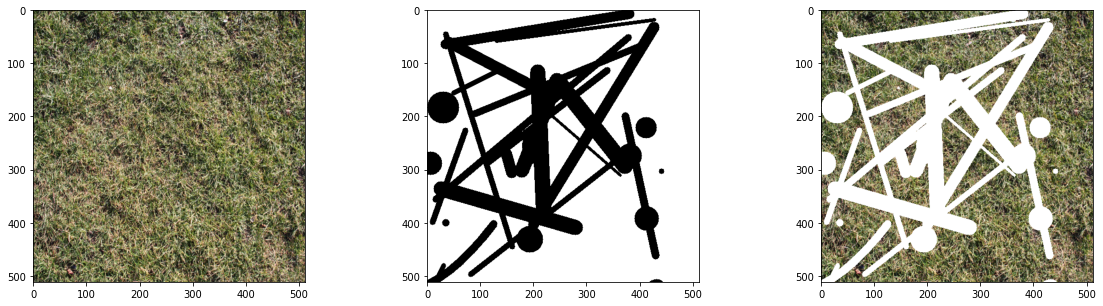

In [ ]:
# Load image
img = cv2.imread('/content/sample_data/1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512)) / 255
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
mask = random_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us. The generator is based off the ImageDataGenerator from keras.processing, which allows us to do all kinds of autmentation more easily. 

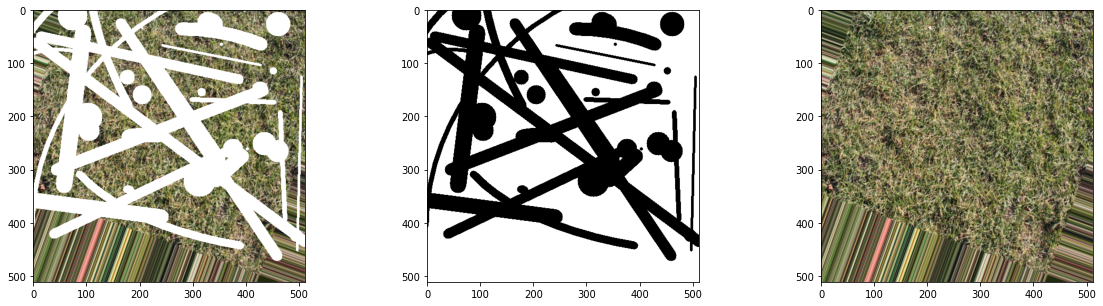

In [ ]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=4)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])

## Training classifier on single image

In [ ]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')                
        plt.show()

Epoch 1/1
10/10 [==============================] - 1422s 142s/step - loss: 2710255.2500


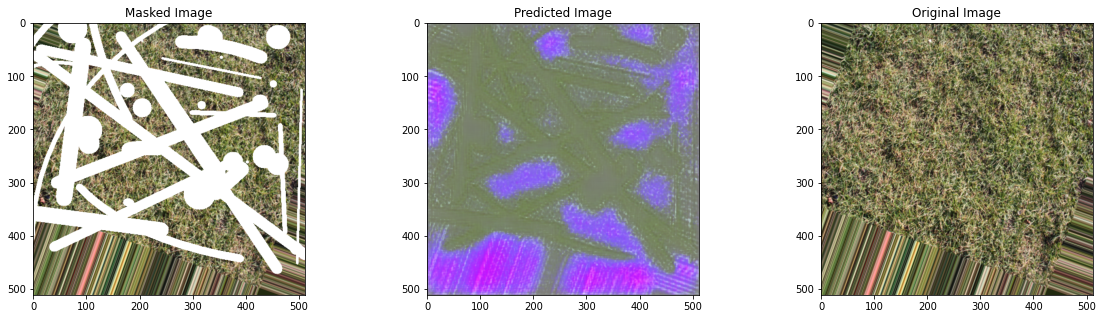

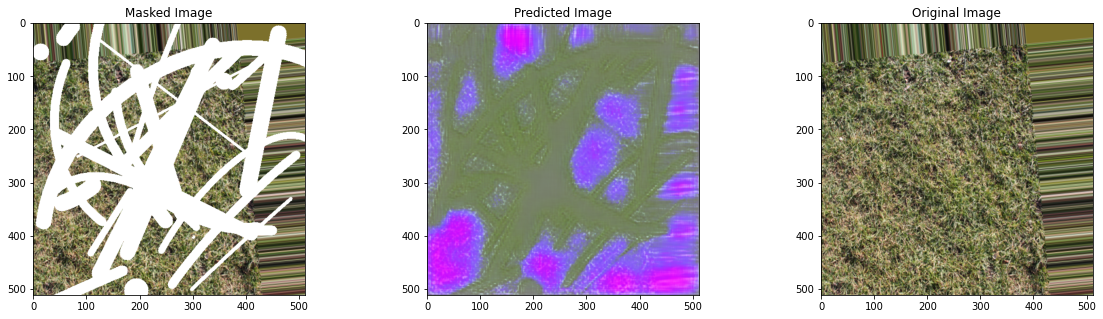

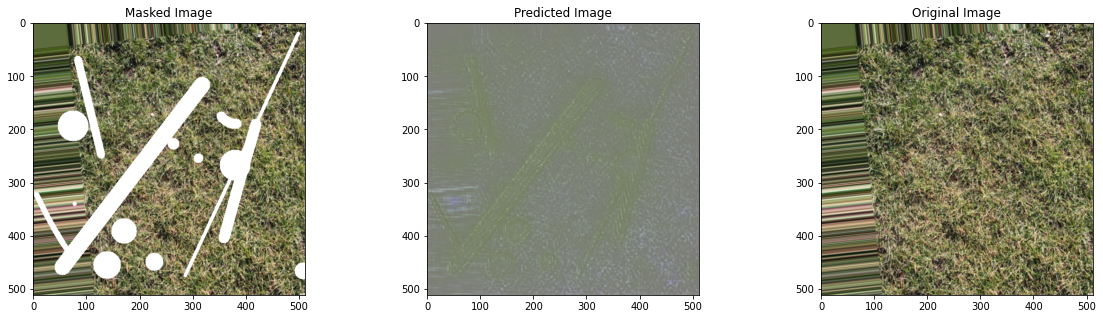

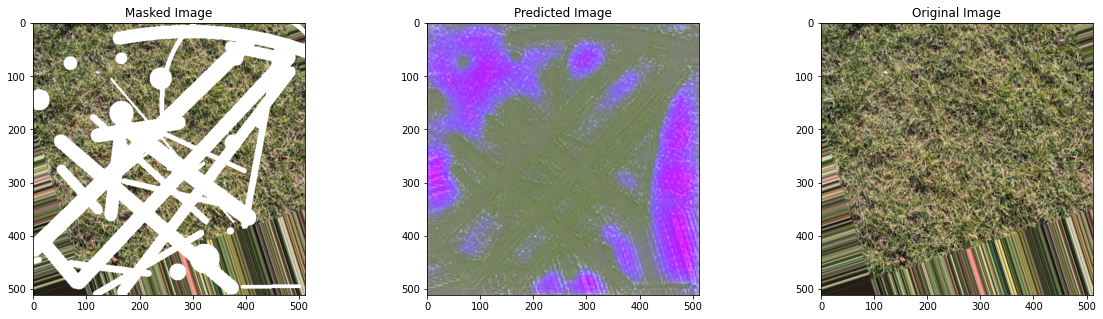

In [ ]:
model = PConvUnet()
model.fit(
    generator, 
    steps_per_epoch=10
    ,
    epochs=1,
    plot_callback=plot_callback,
)